In [84]:
import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision
from torchvision import transforms

In [85]:
trainset = torchvision.datasets.MNIST(root='data/', 
                                      train=True, 
                                      transform = torchvision.transforms.Compose([
                                          transforms.Resize(10),
                                          transforms.ToTensor()]),
                                      download=True)

testset = torchvision.datasets.MNIST(root='data/', 
                                     train=False,
                                     transform = torchvision.transforms.Compose([
                                         transforms.Resize(10), 
                                         transforms.ToTensor()]), 
                                     download=True)

In [86]:
split = 0.1
dataset_size = len(trainset)
indices = list(range(dataset_size))
np.random.shuffle(indices)
val_split = int(np.floor(split * dataset_size))
train_indices = indices[val_split:]
val_indices = indices[:val_split] 

train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

torch.Size([1, 10, 10])
torch.Size([10, 10])
Label: 4


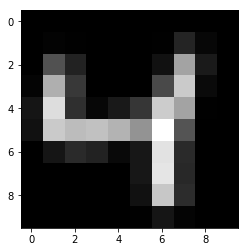

In [87]:
import matplotlib.pyplot as plt
img = trainset[2][0]
print(img.shape)
img = img.reshape(10, 10)
print(img.shape)
print('Label: {}'.format(trainset[2][1].item()))
plt.gray()
plt.imshow(img)

In [115]:
dataloaders = {'train': torch.utils.data.DataLoader(trainset, batch_size=4, sampler=train_sampler),
               'val': torch.utils.data.DataLoader(trainset, batch_size=4, sampler=valid_sampler),
               'test': torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False)
              }

In [116]:
data_lengths = {'train': len(train_indices), 'val': len(val_indices), 'test': len(testset)}

In [117]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(100, 25)
        self.fc2 = nn.Linear(25, 10)
        
    def forward(self, x):
        z1 = F.relu(self.fc1(x.view(4, -1)))
        out = self.fc2(z1)
        return out, z1
    
net = Net()

In [118]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [119]:
num_epochs = 25
fc2_norm = []
fc1_norm = []
train_loss = []
train_acc = []
val_loss = []
val_acc = []

for epoch in range(num_epochs):
    print('Epoch: {}/{}'.format(epoch+1, num_epochs))
    print('='*10)
    
    for phase in ['train', 'val']:
        running_loss = 0.0
        running_corrects = 0
        for i, data in enumerate(dataloaders[phase]):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = net(inputs)
            _, preds = torch.max(outputs[0], 1)
            loss = criterion(outputs[0], labels)
            if phase == 'train':
                loss.backward()
                optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data).item()
        epoch_loss = running_loss/data_lengths[phase]
        epoch_acc = running_corrects/data_lengths[phase]
        
        if phase == 'train':
            fc1_norm.append(net.fc1.weight.grad.norm().item())
            fc2_norm.append(net.fc2.weight.grad.norm().item())
            train_loss.append(epoch_loss)
            train_acc.append(epoch_acc)
        else:
            val_loss.append(epoch_loss)
            val_acc.append(epoch_acc)            
        print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

print('Finished Training')

Epoch: 1/25
train Loss: 0.7894 Acc: 0.7857
val Loss: 0.3880 Acc: 0.8887
Epoch: 2/25
train Loss: 0.3583 Acc: 0.8972
val Loss: 0.3361 Acc: 0.9007
Epoch: 3/25
train Loss: 0.3171 Acc: 0.9081
val Loss: 0.3035 Acc: 0.9118
Epoch: 4/25
train Loss: 0.2916 Acc: 0.9155
val Loss: 0.2791 Acc: 0.9200
Epoch: 5/25
train Loss: 0.2725 Acc: 0.9213
val Loss: 0.2674 Acc: 0.9242
Epoch: 6/25
train Loss: 0.2565 Acc: 0.9259
val Loss: 0.2600 Acc: 0.9243
Epoch: 7/25
train Loss: 0.2430 Acc: 0.9297
val Loss: 0.2467 Acc: 0.9305
Epoch: 8/25
train Loss: 0.2305 Acc: 0.9329
val Loss: 0.2326 Acc: 0.9365
Epoch: 9/25
train Loss: 0.2198 Acc: 0.9358
val Loss: 0.2316 Acc: 0.9355
Epoch: 10/25
train Loss: 0.2106 Acc: 0.9384
val Loss: 0.2178 Acc: 0.9388
Epoch: 11/25
train Loss: 0.2022 Acc: 0.9402
val Loss: 0.2183 Acc: 0.9373
Epoch: 12/25
train Loss: 0.1951 Acc: 0.9431
val Loss: 0.2066 Acc: 0.9407
Epoch: 13/25
train Loss: 0.1880 Acc: 0.9449
val Loss: 0.2024 Acc: 0.9405
Epoch: 14/25
train Loss: 0.1825 Acc: 0.9463
val Loss: 0.2020

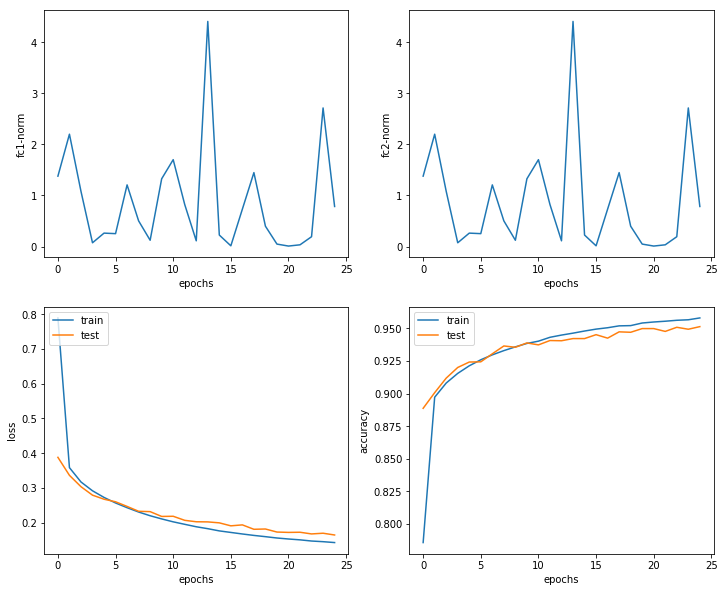

In [127]:
epoch_idx = [i for i in range(num_epochs)]
plt.figure(figsize=(12, 10))

plt.subplot(221)
plt.plot(epoch_idx, fc1_norm)
plt.xlabel('epochs')
plt.ylabel('fc1-norm')

plt.subplot(222)
plt.plot(epoch_idx, fc1_norm)
plt.xlabel('epochs')
plt.ylabel('fc2-norm')


plt.subplot(223)
plt.plot(epoch_idx, train_loss)
plt.plot(epoch_idx, val_loss)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(224)
plt.plot(epoch_idx, train_acc)
plt.plot(epoch_idx, val_acc)
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['train', 'test'], loc='upper left')

plt.show()

In [121]:
running_correct = 0
for data in testloader:
    images, labels = data
    outputs = net(images)
    _, preds = torch.max(outputs[0], 1)
    running_correct += (preds == labels).sum().item()

print('test acc: {}'.format(running_correct/len(testset)))

test acc: 0.9586


In [122]:
torch.save(net, 'trained-models/net_01.pth')

C:\Users\ADMIN\Anaconda3\envs\machlearn\lib\site-packages\torch\serialization.py:241: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [123]:
model = torch.load('trained-models/net_01.pth')

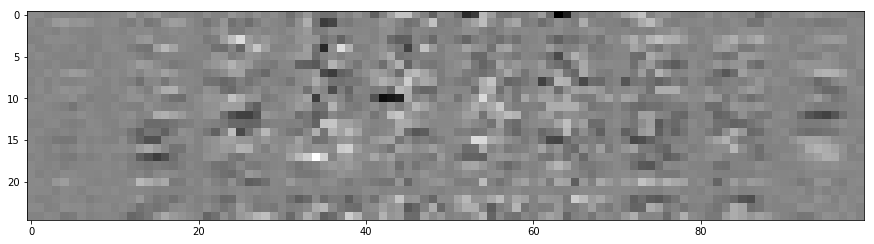

In [125]:
plt.figure(figsize=(15, 5))
plt.imshow(model.fc1.weight.data)

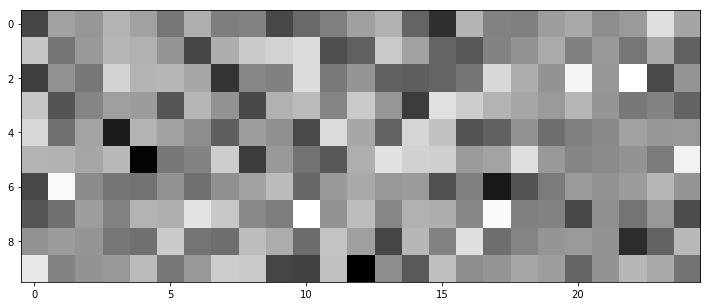

In [126]:
plt.figure(figsize=(15, 5))
plt.imshow(model.fc2.weight.data)